> ### EEE4423: Deep Learning Lab

# LAB #7: High-level Vision - Single Shot Object Detection (YOLO)

<h4><div style="text-align: right"> Due date: APRIL 22, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab07.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2017142136] [이관희]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-04-15 06:30:55.807437


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.autograd import Variable

import torchvision.datasets as dsets

import numpy as np
import cv2

import os
import struct
import copy
import random

import time
import datetime

import math

from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils import data
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

### 1. What is the Object Detection?

>
> <img src="https://drive.google.com/uc?export=view&id=1pOo5As8Qo8bQOQjOkkpRwjVKcKNB4gSE" alt="no_image" style="width: 800px;"/>
>
> - The difference between $\bf{classification}$ (left) and $\bf{detection}$ (right) is simple
>
> - In image classification, the entire image is classified with a single label
>
> - In object detection, the network localizes (potentially multiple) objects within the image
>
> - Therefore, given the image, the obejct detection networks ouput a list of bounding box, class label, and **probability/confidence score**
>

### 2. About YOLO (Main idea)

>
> <img src="https://drive.google.com/uc?export=view&id=1K7tvcGXdRHBc_t5p-m3uyRrCBFbJ9ze5" alt="no_image" style="width: 800px;"/>
>
> - YOLO is an algorithm for object detection
>
> - They reframe object detection as a $\bf{single\ regression\ problem}$, straight from image pixels to bounding box coordinates and class probabilities
>
> - Using YOLO, you only look once (YOLO) at an image to predict what objects are present and where they are
>
> - The advantage of YOLO is the speed, which is extremely fast, since the authors reframe detection as a regression problem not using a complex pipeline
>
> - What are differences between YOLO and previous detectors?? Refer to https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e

### 3. Building a YOLO with PyTorch

> ### YOLO model: 
> - 22Convolutional Layers
>
>     - Note that, first and 20th conv layers have stride 2 for halving output size
>
> - 4 Max Pooling Layers
>
> - 2 Fully Connected Layers
>
> - Leaky ReLu Activation for all layers except for the last layer

### 4. Implementing YOLO
>
> - The input image is divided into an S $\times$ S grid of cells
> 
> - Each grid cell predicts B (=2) bounding boxes as well as C (=20) class probabilities
>
> - Each bounding box consists of 5 predictions: x, y, w, h, and confidence 
> 
> - The (x,y) coordinates represent the center of the box relative to the bounds of the grid cell
> 
> - The width and height are predicted relative to the whole image
>
> - If no object exists in that cell, the confidence score is zero.
>
> - If the cell contains objects, the confidence score is equal to the intersection over union (IOU) between the predicted box and the ground truth (**This is important for building the loss function**)
>
> - Thus, the output vector is a S $\times$ S $\times$ (B $\times$ 5 + C) (= 7 $\times$ 7 $\times$ 30)
> 
> <img src="https://drive.google.com/uc?export=view&id=1LdKtTyYjGKKWmu-4nTYBEMI7n4Sk0aeB" alt="no_image" style="width: 600px;"/>
>
> - You must study *generate_target* function in detail, it contains the process of generating output vectors
>
> Step 1: Load the dataset
>
> Step 2: Build the YOLO network ($\bf{4 points}$)
>> 
>>  <img src="https://drive.google.com/uc?export=view&id=1c4yOWTZacei0_pFoI47wfxVEhM5Tms8X" alt="no_image" style="width: 800px;"/>
>> 
>> - Following the YOLO model, you build yolo network
>> - **Note that our model is different from network of original paper. Please follow above figure.**
>> - You must fill out the blank in **self.pre_train_net** and **self.post_net** blocks
>> - All layers use the following Leaky ReLU (0.01 slope for negative part - Note that it is different from the paper)
>>
>>
>> #### **self.pre_train_net**
>> 
>>
>>
>>| Name       | Filters              | Output Dimension | Padding |
>>|------------|----------------------|------------------| ------- |    
>>| Conv 1     | 7 x 7 x 64, stride=2 | 224 x 224 x 64   | 3       |
>>| LeakyReLU  | negative_slop=0.01   | 224 x 224 x 64   |         |
>>| Max Pool 1 | 2 x 2, stride=2      | 112 x 112 x 64   |         | 
>>|
>>| Conv 2     | 3 x 3 x 192          | 112 x 112 x 192  | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 112 x 112 x 192  |         |
>>| Max Pool 2 | 2 x 2, stride=2      | 56 x 56 x 192    |         | 
>>|
>>| Conv 3     | 1 x 1 x 128          | 56 x 56 x 128    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 56 x 56 x 128    |         |
>>| Conv 4     | 3 x 3 x 256          | 56 x 56 x 256    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 56 x 56 x 256    |         |
>>| Conv 5     | 1 x 1 x 256          | 56 x 56 x 256    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 56 x 56 x 256    |         |
>>| Conv 6     | 3 x 3 x 512          | 56 x 56 x 512    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 56 x 56 x 512    |         |
>>| Max Pool 3 | 2 x 2, stride=2      | 28 x 28 x 512    |         | 
>>|
>>| Conv 7     | 1 x 1 x 256          | 28 x 28 x 256    | 0       | 
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 256    |         |
>>| Conv 8     | 3 x 3 x 512          | 28 x 28 x 512    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 512    |         |
>>| Conv 9     | 1 x 1 x 256          | 28 x 28 x 256    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 256    |         |
>>| Conv 10    | 3 x 3 x 512          | 28 x 28 x 512    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 512    |         |
>>| Conv 11    | 1 x 1 x 256          | 28 x 28 x 256    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 256    |         |
>>| Conv 12    | 3 x 3 x 512          | 28 x 28 x 512    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 512    |         |
>>| Conv 13    | 1 x 1 x 256          | 28 x 28 x 256    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 256    |         |
>>| Conv 14    | 3 x 3 x 512          | 28 x 28 x 512    | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 512    |         |
>>| Conv 15    | 1 x 1 x 512          | 28 x 28 x 512    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 512    |         |
>>| Conv 16    | 3 x 3 x 1024         | 28 x 28 x 1024   | 1       |
>>| LeakyReLU  | negative_slop=0.01   | 28 x 28 x 1024   |         |
>>| Max Pool 4 | 2 x 2, stride=2      | 14 x 14 x 1024   |         | 
>>|
>>| Conv 17    | 1 x 1 x 512          | 14 x 14 x 512    | 0       |
>>| LeakyReLU  | negative_slop=0.01   | 14 x 14 x 512    |         |
>>| Conv 18    | 3 x 3 x 1024         | 14 x 14 x 1024   | 1       | 
>>| LeakyReLU  | negative_slop=0.01   | 14 x 14 x 1024   |         |
>>
>> #### **self.post_net**
>>
>>| Name      | Filters                | Output Dimension | Padding | 
>>|-----------|------------------------|------------------| ------- | 
>>| Conv 19   | 3 x 3 x 1024           | 14 x 14 x 1024   | 1       | 
>>| LeakyReLU | negative_slop=0.01     | 14 x 14 x 1024   |         |
>>| Conv 20   | 3 x 3 x 1024, stride=2 | 7 x 7 x 1024     | 1       | 
>>| LeakyReLU | negative_slop=0.01     | 7 x 7 x 1024     |         |
>>| Conv 21   | 3 x 3 x 1024           | 7 x 7 x 1024     | 1       |
>>| LeakyReLU | negative_slop=0.01     | 7 x 7 x 1024     |         |
>>| Conv 22   | 3 x 3 x 1024           | 7 x 7 x 1024     | 1       |
>>| LeakyReLU | negative_slop=0.01     | 7 x 7 x 1024     |         |
>>
> Step 3: Loss function ($\bf{6 points}$)
>
>> - Fill out the code considering the loss function in YOLO
>> - The loss function is composed like below
>> <img src="https://drive.google.com/uc?export=view&id=1QcAP__J50M379GAul7SlhAzzU551tuDj" alt="no_image" style="width: 600px;"/>
>>
>> - $\mathbb{1}_{obj}$ is defined as follows:
>>    - 1, if an object is present in grid cell $i$ and the $j$th bounding box predictor
>>    - 0, otherwise
>>
>> - YOLO predicts multiple bounding boxes per grid cell (in our case, 2 bounding boxes are predicted)
>> - In train stage, YOLO requires one bounding box predictor to be responsible for each object 
>> - The code assigns one predictor to be "responsible" for predicting an object where the predictor has the highest IOU with the ground truth
>> - The loss function is divided into the three sub-sections
>>    1. Classification ( $\bf{6}$ classes ) ($\bf{2 points}$)
>>       <img src="https://drive.google.com/uc?export=view&id=13mnxg_GNtbWnYLpe1P6zopf693zTYe22" alt="no_image" style="width: 300px;"/>
>>
>>       - Similar to sum-squared error for classification except for $\mathbb{1}_{obj}$ term
>>
>>       - Note that, we do not penalize classification error when no object is present on the cell (by $\mathbb{1}_{obj}$ term)
>>
>>    2. No object appears in cell ($\bf{2 points}$)
>>       <img src="https://drive.google.com/uc?export=view&id=1R74HzbRLoX2K5zun8XSLAnRQlKq25XFV" alt="no_image" style="width: 300px;"/>
>>
>>       - Compute the loss associated with the confidence score for each bounding box predictor
>>
>>       - $\mathbb{1}_{noobj}$ is equal to one when there is no object in the cell, and 0 other wise
>>    3. Bounding box coordinates (x,y,h,w) regression (4 scalars), and Object confidence ($\bf{2 points}$)
>>       <img src="https://drive.google.com/uc?export=view&id=1lXs5lHUiXGxgMRNCiViY6SyRDL52gQsy" alt="no_image" style="width: 600px;"/>
>>
>>       - Compute the loss realted to the predicted bounding box position $(x,y)$ and width/height $(w,h)$
>>
>>       - Note that width/height are adapted square root before computing the loss
>>
>>       - In order to solve the problem that small deviations in large boxes matter less than in small boxes
>>
>>       - Compute the loss associated with the confidence score for the cell which is responsible for the object
>>
>> - Following the paper, $\lambda_{coord} = 5$ and $\lambda_{noobj} = 0.5$
>>
> Step 4: Train Model ($\bf{2 points}$)
>>
>> - Based on the above code, you build train code on your own
>> - The necessary things are provided (e.g., *optimizer* and *num_epoch*)
>> - Note that, we offer the pre-trained model since it requires large training time.
>> - If you construct your code correctly, the performance of mAP will be over 0.69 mAP in 10 epochs (about 15 minitues.)
>>
> Step 5: Inference
>>
>> - We offer the test code in below
>> - You can check the qualitative results using the visualization code
>> - The quantitative results will be evaluated by using the mAP code
>> - If the performance of mAP is significantly decreased from the pre-trained model (0.685 mAP), your code will be wrong
>>
>> Step 5-1: Inference (Visualization)
>> 
>> Step 5-2: Inference (mAP) 

### Step 1. Load the dataset

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# train_dataset = YoloDataset(root=file_root, list_file='./misc/lab07/Generate_dataset/voc2007+2012.txt', train=True)

class YoloDataset(data.Dataset):
    def __init__(self, root, list_file, train, transform=None):
        self.image_size = 448 # input image size
        self.root = root   # image file 위치
        self.train = train  # train 인지 아닌지
        self.transform = transform
        self.fnames = [] # file name
        self.boxes = []
        self.labels = []
        self.color_jitter = Compose([transforms.ColorJitter(brightness=0.1,contrast=0.1, saturation=0.1, hue=0.1),
                                                 transforms.ToTensor()])
        # Randomly change the brightness, contrast, saturation and hue of an image.
        self.plain = Compose([transforms.ToTensor()])
        self.resize = Compose([transforms.ToPILImage(),
                              transforms.Resize((self.image_size, self.image_size)),
                              transforms.ToTensor()])
        # input image size를 448 x 448 로 만듦
        
        with open(list_file) as f:
            lines = f.readlines()
            
        for line in lines:
            splited = line.strip().split()
            # line.strip()으로 화이트 스페이스를 없앰
            self.fnames.append(splited[0])
            num_boxes = (len(splited) - 1) // 5 # 이미지의 bounding box 수
            box = []
            label = []
            for i in range(num_boxes):
                x_min = float(splited[1+5*i])
                y_min = float(splited[2+5*i])
                x_max = float(splited[3+5*i])
                y_max = float(splited[4+5*i])
                c = splited[5+5*i]
                box.append([x_min, y_min, x_max, y_max])
                label.append(int(c)+1)
                # 질문 : confidence에 1을 더하는 이유 or label에 1을 더하는 이유? -> back ground label 삽입
            self.boxes.append(torch.Tensor(box))
            self.labels.append(torch.LongTensor(label))
        self.num_samples = len(self.boxes) # 총 box 수
        
    # pre_processing 안쓰는 것 같음
    def img_pre_process(self, img, boxes, labels):
        
        if random.random() < 0.5: # 50%가량의 확률로 flip
            im_lr = np.fliplr(img).copy()
            height, width, c = img.shape
            x_min = width - boxes[:, 2]
            x_max = width - boxes[:, 0]
            boxes[:,0] = x_min
            boxes[:,2] = x_max
            img = im_lr
        
        ## Converting the image and box information scaling
        if random.random() < 0.5:
            scale = random.uniform(0.8, 1.2)
            height, width, c = img.shape
            img = cv2.resize(img, (int(width * scale), height))
            boxes = boxes * torch.FloatTensor([[scale, 1, scale, 1]]).expand_as(boxes)
            
        ## Image translation
        if random.random() < 0.5:
            center = (boxes[:,2:] + boxes[:,:2]) / 2
            height, width, c = img.shape
            shifted_img = np.zeros((height, width, c), dtype=img.dtype)
            
            w_range = int(random.uniform(-width*0.2, width*0.2))
            h_range = int(random.uniform(-height*0.2, height*0.2))
            
            if w_range<0 and h_range<0:
                shifted_img[:height+h_range,:width+w_range,:] = img[-h_range:,-w_range:,:]
                
            elif w_range<0 and h_range>=0:
                shifted_img[h_range:,:width+w_range,:] = img[:height-h_range,-w_range:,:]
            
            elif w_range>=0 and h_range>=0:
                shifted_img[h_range:,w_range:,:] = img[:height-h_range,:width-w_range,:]
                
            elif w_range>=0 and h_range<0:
                shifted_img[:height+h_range,w_range:,:] = img[-h_range:,:width-w_range,:]
                
            wh_range = torch.FloatTensor([[w_range, h_range]]).expand_as(center)
            center = center + wh_range
            
            mask1 = (center[:,0] > 0) & (center[:,0] < width)
            mask2 = (center[:,1] > 0) & (center[:,1] < height)
            mask = (mask1 & mask2).view(-1,1).bool()
            
            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            
            if len(boxes_in) != 0:
                box_shift = torch.FloatTensor([[w_range, h_range, w_range, h_range]]).expand_as(boxes_in)
                boxes_in = boxes_in + box_shift
                
                labels_in = labels[mask.view(-1)]
                labels = labels_in
                img = shifted_img
                boxes = boxes_in
        
        ## Image cropping
        if random.random() < 0.5:
            center = (boxes[:,2:] + boxes[:,:2]) / 2
            height, width, c = img.shape
            h = int(random.uniform(0.6*height,height))
            w = int(random.uniform(0.6*width,width))
            x = int(random.uniform(0,width-w))
            y = int(random.uniform(0,height-h))
            
            center = center - torch.FloatTensor([[x, y]]).expand_as(center)
            mask1 = (center[:,0]>0) & (center[:,0]<w)
            mask2 = (center[:,1]>0) & (center[:,1]<h)
            mask = (mask1 & mask2).view(-1, 1).bool()
            
            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            
            if (len(boxes_in)!=0):
                box_shift = torch.FloatTensor([x,y,x,y]).expand_as(boxes_in)

                boxes_in = boxes_in - box_shift
                boxes_in[:,0]=boxes_in[:,0].clamp_(min=0,max=w)
                boxes_in[:,2]=boxes_in[:,2].clamp_(min=0,max=w)
                boxes_in[:,1]=boxes_in[:,1].clamp_(min=0,max=h)
                boxes_in[:,3]=boxes_in[:,3].clamp_(min=0,max=h)

                labels = labels[mask.view(-1)]
                img_cropped = img[y:y+h, x:x+w, :]
                boxes = boxes_in
                img = img_cropped
        
        return img, boxes, labels
    
    # 중요 label을 만드는 코드
    def generate_target(self, img, boxes, labels):
        grid_size = 7
        h,w,_ = img.shape
        boxes /= torch.Tensor([w,h,w,h]).expand_as(boxes) # Converting the box size 0 ~ 1
        # expand_as 텐서은 텐서의 매개 변수의 크기로 확대했다.
        target = torch.zeros((grid_size, grid_size, 30)) 
        cell_size = 1./grid_size 

        #x_min, y_min, x_max, y_max
        wh = boxes[:,2:] - boxes[:,:2] # w,h의 크기가 나올 것이다.
        cxcy = (boxes[:,2:] + boxes[:,:2]) / 2 # 중심 좌표가 나올 것이다.
        
        for i in range(cxcy.size()[0]):
            cxcy_sample = cxcy[i] # center pixel 
            ij = (cxcy_sample/cell_size).ceil()-1 
            # 질문 : ij가 의미하는 것은 무엇인가요? 위에서 Converting the box size 0 ~ 1 로 바꾸었기 때문에 최대 6이 나온다.
            target[int(ij[1]),int(ij[0]),4] = 1
            target[int(ij[1]),int(ij[0]),9] = 1
            target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1
            
            xy = ij*cell_size 
            delta_xy = (cxcy_sample -xy)/cell_size # Converting delta_xy to the size 
                                                   # relative to the bounds of the grid cell
            target[int(ij[1]),int(ij[0]),2:4] = wh[i]
            target[int(ij[1]),int(ij[0]),:2] = delta_xy
            target[int(ij[1]),int(ij[0]),7:9] = wh[i]
            target[int(ij[1]),int(ij[0]),5:7] = delta_xy
            
        return target
    
    def RandomBrightness(self,bgr):
        if random.random() < 0.5:
            hsv = cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            v = v*adjust
            v = np.clip(v, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        return bgr
    def RandomSaturation(self,bgr):
        if random.random() < 0.5:
            hsv = cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            s = s*adjust
            s = np.clip(s, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        return bgr
    def RandomHue(self,bgr):
        if random.random() < 0.5:
            hsv = cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            h = h*adjust
            h = np.clip(h, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        return bgr

    def randomBlur(self,bgr):
        if random.random()<0.5:
            bgr = cv2.blur(bgr,(5,5))
        return bgr
        
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.imread(os.path.join(self.root+fname))
        boxes = self.boxes[idx].clone()
        labels = self.labels[idx].clone()

        if self.train:
            img = self.randomBlur(img)
            img = self.RandomBrightness(img)
            img = self.RandomHue(img)
            img = self.RandomSaturation(img)
            img, boxes, labels = self.img_pre_process(img, boxes, labels)
            
        target = self.generate_target(img, boxes, labels) # 7x7x30
        
        # Image processing
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = self.plain(img)
        img = self.resize(img)
        img = 2 * img - 1
        
        return img, target
    
    def __len__(self):
        return self.num_samples
            

In [4]:
torch.Tensor([500,500,500,500]).expand_as(torch.Tensor([[12,60,800,307],[12,60,800,307]]))

tensor([[500., 500., 500., 500.],
        [500., 500., 500., 500.]])

In [5]:
torch.Tensor([12,60,800,307])/torch.Tensor([500,500,500,500]) # Converting the box size 0 ~ 1

tensor([0.0240, 0.1200, 1.6000, 0.6140])

### Step 2. Build the YOLO network (2 points)

> You should build model using nn.Sequential. Otherwise, problem arises when loading pretrained weights.

In [6]:
class YOLO(nn.Module):
    def __init__(self):
        super(YOLO, self).__init__()
        
        self.pre_train_net = nn.Sequential(
            #conv1 -> LeakyReLU -> Max Pool1
            nn.Conv2d(3, 64,7,stride=2, padding =3),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            
            #conv2 -> LeakyReLU -> Max Pool2
            nn.Conv2d(64, 192, 3,stride=1, padding =1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            
            # conv3 -> LeakyReLU
            nn.Conv2d(192, 128, 1, stride=1, padding = 0),
            nn.LeakyReLU(0.01) ,
            
            # conv4 -> LeakyReLU
            nn.Conv2d(128, 256, 3, stride=1, padding = 1),
            nn.LeakyReLU(0.01) ,
            
            # conv5 -> LeakyReLU
            nn.Conv2d(256, 256, 1, stride=1, padding = 0),
            nn.LeakyReLU(0.01) ,
            
            # conv6 -> LeakyReLU -> Max Pool3
            nn.Conv2d(256, 512,3,stride=1, padding =1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            
            # conv7 -> LeakyReLU
            nn.Conv2d(512, 256, 1, stride=1, padding = 0),
            nn.LeakyReLU(0.01) ,
            
            # conv8 -> LeakyReLU
            nn.Conv2d(256, 512, 3, stride=1, padding = 1),
            nn.LeakyReLU(0.01) ,
            
            # conv9 -> LeakyReLU
            nn.Conv2d(512, 256, 1, stride=1, padding = 0),
            nn.LeakyReLU(0.01) ,
            
            # conv10 -> LeakyReLU
            nn.Conv2d(256, 512, 3, stride=1, padding = 1),
            nn.LeakyReLU(0.01) ,
            
            # conv11 -> LeakyReLU
            nn.Conv2d(512, 256, 1, stride=1, padding = 0),
            nn.LeakyReLU(0.01) ,
            
            # conv12 -> LeakyReLU
            nn.Conv2d(256, 512, 3, stride=1, padding = 1),
            nn.LeakyReLU(0.01) ,
            
            # conv13 -> LeakyReLU
            nn.Conv2d(512, 256, 1, stride=1, padding = 0),
            nn.LeakyReLU(0.01) ,
            
            # conv14 -> LeakyReLU
            nn.Conv2d(256, 512, 3, stride=1, padding = 1),
            nn.LeakyReLU(0.01) ,
            
            # conv15 -> LeakyReLU
            nn.Conv2d(512, 512, 1, stride=1, padding = 0),
            nn.LeakyReLU(0.01) ,
            
            # conv16 -> LeakyReLU -> Max pool4
            nn.Conv2d(512, 1024, 3, stride=1, padding = 1),
            nn.LeakyReLU(0.01) ,
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            
            # conv17 -> LeakyReLU
            nn.Conv2d(1024, 512, 1, stride=1, padding = 0),
            nn.LeakyReLU(0.01) ,
            
            # conv18 -> LeakyReLU
            nn.Conv2d(512, 1024, 3, stride=1, padding = 1),
            nn.LeakyReLU(0.01) ,
        )
        
        self.post_net = nn.Sequential(
            # conv19 -> LeakyReLU
            nn.Conv2d(1024, 1024, 3, stride=1, padding = 1),
            nn.LeakyReLU(0.01) ,
            
            # conv20-> LeakyReLU
            nn.Conv2d(1024, 1024, 3, stride=2, padding = 1),
            nn.LeakyReLU(0.01) ,
            
            # conv21 -> LeakyReLU
            nn.Conv2d(1024, 1024, 3, stride=1, padding = 1),
            nn.LeakyReLU(0.01) ,
            
            # conv22 -> LeakyReLU
            nn.Conv2d(1024, 1024, 3, stride=1, padding = 1),
            nn.LeakyReLU(0.01) ,
        )
        
        self.FC1 = nn.Sequential(
            nn.Linear(50176, 4096),
            nn.LeakyReLU(),
            nn.Dropout()
        )
        
        self.FC2 = nn.Sequential(
            nn.Linear(4096, 1470)
        )
        
        self.pre_train_net.cuda()
        self.post_net.cuda()
        self.FC1.cuda()
        self.FC2.cuda()
        
        self._initialize_weights()

    def forward(self, x):
        output = self.pre_train_net(x)
        output = self.post_net(output)

        # Ready to going for FC layer
        output = output.view(output.size(0), -1)

        output = self.FC1(output)
        output = self.FC2(output)

        output = output.view(output.size(0), 7, 7, 30)
        # Converting the output shape to the (batch_size, 7, 7, 30)
        output = F.relu(output)

        return output
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

### Step 3. Loss function (6 points)

In [7]:
class yoloLoss(nn.Module):
    def __init__(self,l_coord,l_noobj):
        super(yoloLoss,self).__init__()
        self.l_coord = l_coord
        self.l_noobj = l_noobj
    
    def compute_prob_error(self, pred, target): ## classification error
        contain = target[:,:,:,4] > 0 # [Batch_size, 7, 7, 1]
        contain = contain.unsqueeze(3).expand_as(target) # [Batch_size, 7, 7, 30]

        contain_pred = pred[contain].view(-1, 30)          # [n_coord, 30]
                                                           # n_coord: object가 있는 cell의 수
        contain_target = target[contain].view(-1, 30)      # [n_coord, 30]
                                                           # n_coord: object가 있는 cell의 수
        class_pred = contain_pred[:, 5*2:] 
        class_target = contain_target[:, 5*2:]
        prob_loss = F.mse_loss(class_pred, class_target, reduction='sum')

        return prob_loss
    
    # 위의 loss로 인해서 우리는 object가 존재하는 cell에 대해서 class probability를 학습 시킬 수 있다. 
    
    def not_contain_obj_error(self, pred, target): ## Error where no object appears in cell
        not_contain = target[:,:,:,4] == 0 # [Batch_size, 7, 7, 1]
        not_contain = not_contain.unsqueeze(3).expand_as(target) # [Batch_size, 7, 7, 30]

        not_obj_pred = pred[not_contain].view(-1,30) # [n_noobj, 30] n_noobj cell에 object가 없는 수
        not_obj_target = target[not_contain].view(-1,30) # [n_noobj, 30] n_noobj cell에 object가 없는 수
        
        not_obj_conf_mask = torch.cuda.ByteTensor(not_obj_pred.size()).fill_(0) # [n_noobj, 30]
        for b in range(2):
            not_obj_conf_mask[:, 4 + b*5] = 1 # not_obj_conf_mask[:, 4] = 1; not_obj_conf_mask[:, 9] = 1
        
        not_obj_pred_conf = not_obj_pred[not_obj_conf_mask]       #  object가 없는 confidence score만 추출 
                                                                  # [n_noobj, 2=len([conf1, conf2])]
        not_obj_target_conf = not_obj_target[not_obj_conf_mask]   #  object가 없는 confidence score만 추출 
                                                                  # [n_noobj, 2=len([conf1, conf2])]
        noobj_loss1 = F.mse_loss(not_obj_pred_conf, not_obj_target_conf, reduction='sum')
        
        return noobj_loss1
    
    # 이 loss를 가지고 우리는 background로 추출하는 confidence score을 0으로 만들도록 학습시킬 수 있다.
    
    
    def contain_obj_error(self, pred, target): ##
        contain = target[:,:,:,4] > 0 # [Batch_size, 7, 7, 1]
        contain = contain.unsqueeze(3).expand_as(target) # [Batch_size, 7, 7, 30]
        
        contain_pred = pred[contain].contiguous().view(-1,30) # Only cell which contains the object are remained
        box_pred = contain_pred[:,:10].contiguous().view(-1,5) # Reshaping [n_coord x 2, 5=len([x, y, w, h, conf])]
        
        contain_target = target[contain].contiguous().view(-1,30) # Only cell which contains the object are remained
        box_target = contain_target[:,:10].contiguous().view(-1,5)# Reshaping [n_coord x 2, 5=len([x, y, w, h, conf])]
        
        # Note that, We assign one predictor to be "responsible" for predicting 
        # an object based on which prediction has the highest current IOU with the ground truth
        # Then, other prediction is "not responsible" for predicting an object
        # That component is included in "contain_noobj_mask variables
        
        contain_obj_mask = torch.cuda.ByteTensor(box_target.size()).zero_().bool() # Create the mask
        contain_noobj_mask = torch.cuda.ByteTensor(box_target.size()).zero_().bool() 
        
        target_iou_gt = torch.zeros(box_target[:,0].size()).cuda() # In order to save the IoU for confidence 
                                                                   # of the cell which contains object
                                                                   # [n_coord x 2,]
        
        for i in range(0, box_target.size()[0], 2):
            box_p = box_pred[i:i+2] # For 2 bounding boxes information [2,5=len([x, y, w, h, conf]]
            box_p_coord = Variable(torch.FloatTensor(box_p.size())) # Box coordinate (x_min, y_min, x_max, y_max)
            # [2, 5=len([x, y, w, h, conf])]
            
            box_p_coord[:,:2] = box_p[:, :2]/float(7) - 0.5 * box_p[:, 2:4] ## Fill out 
            # box의 x_min과 y_min을 나타낸다. 여기서 7로 나누어준 이유는
            # data를 발생시킬 때 0,1사이로 nomalize해주었고 이를 다시 7등분했기 때문이다.
            box_p_coord[:,2:4] = box_p[:, :2]/float(7) + 0.5 * box_p[:, 2:4] ## Fill out
            
            box_t = box_target[i].contiguous().view(-1,5)
            box_t_coord = Variable(torch.FloatTensor(box_t.size()))
            box_t_coord[:,:2] = box_t[:, :2]/float(7) - 0.5 * box_t[:, 2:4]## Fill out
            box_t_coord[:,2:4] = box_t[:, :2]/float(7) + 0.5 * box_t[:, 2:4]## Fill out
            
            iou = self.compute_iou(box_p_coord[:,:4], box_t_coord[:,:4]) # [2,]
                                                      # compute IoU between prediction and target boxes, 
            
            gt_iou, max_idx = iou.max(0)
            contain_obj_mask[i+max_idx] = 1
            contain_noobj_mask[i+1-max_idx] = 1
            
            target_iou_gt[i+max_idx] = gt_iou.data.cuda()
            
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        target_iou_gt = target_iou_gt.to(device)
        
        ## For the cell which contains object
        contain_box_pred = box_pred[contain_obj_mask].view(-1, 5)  # [number_response(=n_coord), 5] ## Fill out 
        # contain_obj_mask shape [n_coord x 2, 5=len([x, y, w, h, conf])]
        
        ## For the cell which does not contain object
        not_contain_box_pred = box_pred[contain_noobj_mask].view(-1, 5)## Fill out 

        ## For target domain 
        contain_box_target = box_target[contain_obj_mask].view(-1, 5) # [number_response, 5] Fill out
        not_contain_box_target = box_target[contain_noobj_mask].view(-1, 5)## Fill out
        not_contain_box_target[:,4] = 0
        
        ## For the GT IoU 
        contain_iou_target = target_iou_gt[contain_obj_mask[:,0]] ## Fill out 
        # target_iou_gt -> [n_coord x 2,]  contain_obj_mask -> [n_coord x 2, 5], contain_iou_target -> [n_coord,]
        
        obj_loss = F.mse_loss(contain_box_pred[:,4], contain_iou_target, size_average=False)
        xy_loss = F.mse_loss(contain_box_pred[:,:2], contain_box_target[:,:2], size_average=False)
        wh_loss = F.mse_loss(torch.sqrt(contain_box_pred[:,2:4]), torch.sqrt(contain_box_target[:,2:4]), size_average=False)
        noobj_loss2 = F.mse_loss(not_contain_box_pred[:,4], not_contain_box_target[:,4], size_average=False)
        
        return obj_loss, xy_loss, wh_loss, noobj_loss2
        
    def compute_iou(self, box_p, box_t):
        
        pred_area = (box_p[:,2] - box_p[:,0]) * (box_p[:,3] - box_p[:,1]) # [2,] 한 cell당 2개씩 예상하므로
        target_area = (box_t[:,2] - box_t[:,0]) * (box_t[:,3] - box_t[:,1]) #[1,] ground truth는 한개
        
        box_p = box_p.unsqueeze(1).expand(2,1,4)
        box_t = box_t.unsqueeze(0).expand(2,1,4)
        
        # pred과 target box가 있다고 생각해보자 그러면 교집합부분을 구하기 위해서는 작은 사각형의 꼭짓점의 좌표를 알아야한다.
        # 이때 pixel은 왼쪽 위부터 0,0으로 세기 때문에 lt는 교집합 사각형의 왼쪽 윗부분을 
        # rb는 교집합 사각형의 오른쪽 아랫부분을 지칭하게 된다. 
        
        inter_lt = torch.max(box_p[:,:,:2], box_t[:,:,:2]) # [2,1,2]
        
        inter_rb = torch.min(box_p[:,:,2:], box_t[:,:,2:]) # [2,1,2]
        
        wh = inter_rb - inter_lt # [2,1,2]
        wh[wh<0] = 0 # 음수라는 것은 교집합 부분이 없다는 뜻이다.
        
        inter_area = wh[:,:,0] * wh[:,:,1] # [2,1]
        pred_area = pred_area.unsqueeze(1).expand_as(inter_area)
        target_area = target_area.unsqueeze(0).expand_as(inter_area)
        
        iou = inter_area / (pred_area + target_area - inter_area)
        
        return iou # [2,1] -> 한 cell 당 2개의 bounding box의 iou가 출력으로 나오게 되는 것이다.
    
    
    def forward(self,pred,target):

        batch_size = pred.size()[0]
        
        noobj_loss1 = self.not_contain_obj_error(pred, target)
        prob_loss = self.compute_prob_error(pred, target)
        obj_loss, xy_loss, wh_loss, noobj_loss2 = self.contain_obj_error(pred, target)
        
        total_loss = (self.l_coord*(xy_loss + wh_loss) + obj_loss + self.l_noobj*(noobj_loss1 + noobj_loss2) + prob_loss)
        
        return total_loss / batch_size
        

In [8]:
target_tensor = torch.rand(3,3)
print(target_tensor)
coord_mask = target_tensor[:, 2] > 0.3
print(coord_mask)
coord_mask = coord_mask.unsqueeze(-1).expand_as(target_tensor)
print(coord_mask)

tensor([[0.0856, 0.3958, 0.2558],
        [0.6804, 0.2057, 0.6337],
        [0.2680, 0.4336, 0.0959]])
tensor([False,  True, False])
tensor([[False, False, False],
        [ True,  True,  True],
        [False, False, False]])


In [9]:
pred_tensor = torch.rand(3,3)
print(pred_tensor)
coord_pred = pred_tensor[coord_mask].view(-1, 3) 
print(coord_pred)

tensor([[0.3162, 0.9466, 0.3463],
        [0.1234, 0.6657, 0.1010],
        [0.6365, 0.2590, 0.0635]])
tensor([[0.1234, 0.6657, 0.1010]])


In [10]:
not_obj_conf_mask = torch.cuda.ByteTensor(coord_pred.size()).fill_(0)
print(not_obj_conf_mask)

not_obj_conf_mask[:, 2] = 1 # not_obj_conf_mask[:, 4] = 1; not_obj_conf_mask[:, 9] = 1
print(not_obj_conf_mask)

print(coord_pred[not_obj_conf_mask])

tensor([[0, 0, 0]], device='cuda:0', dtype=torch.uint8)
tensor([[0, 0, 1]], device='cuda:0', dtype=torch.uint8)
tensor([0.1010])


/tmp/ipykernel_36468/820352365.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  print(coord_pred[not_obj_conf_mask])


In [11]:
pred_tensor = torch.rand(3,3)
pred_tensor[1]=1
print(pred_tensor)

tensor([[0.1481, 0.9198, 0.6179],
        [1.0000, 1.0000, 1.0000],
        [0.5609, 0.8851, 0.0982]])


### Step 4. Train the model

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
file_root = '../dataset/lab07/all_img/'
train_dataset = YoloDataset(root=file_root, list_file='./misc/lab07/Generate_dataset/voc2007+2012.txt', train=True)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)

model = YOLO()
state_dict = torch.load('./pretrain/lab07/pre_train.pt')
model.load_state_dict(state_dict['state_dict'])
print('pre_train_complete')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer.load_state_dict(state_dict['optimizer'])

criterion = yoloLoss(l_coord=5,l_noobj=0.5)

best = 1e+30
num_epochs = 15
print("training start!")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
        
    for i, (images, target) in enumerate(train_loader):
        images = images.to(device)
        target = target.to(device)
        
        pred = model(images)
        loss = criterion(pred, target)
        
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print('Epoch [%d/%d], Iter [%d,%d] Loss:%.4f, average_loss: %.4f' % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))

pre_train_complete
training start!


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [10,430] Loss:0.7407, average_loss: 0.6899


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [20,430] Loss:0.9655, average_loss: 0.7396


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [30,430] Loss:0.4887, average_loss: 0.6634


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [40,430] Loss:0.4860, average_loss: 0.6423


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [50,430] Loss:0.9016, average_loss: 0.6573


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [60,430] Loss:0.4722, average_loss: 0.6732


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [70,430] Loss:0.9689, average_loss: 0.6758


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [80,430] Loss:0.6617, average_loss: 0.6834


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [90,430] Loss:0.8498, average_loss: 0.6748


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [100,430] Loss:0.5914, average_loss: 0.6629


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [110,430] Loss:0.5902, average_loss: 0.6616


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [120,430] Loss:0.3726, average_loss: 0.6622


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [130,430] Loss:0.5456, average_loss: 0.6681


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [140,430] Loss:1.1104, average_loss: 0.6739


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [150,430] Loss:0.2879, average_loss: 0.6753


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [160,430] Loss:0.3977, average_loss: 0.6721


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [170,430] Loss:1.0988, average_loss: 0.6790


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [180,430] Loss:0.5083, average_loss: 0.6787


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [190,430] Loss:0.5760, average_loss: 0.6797


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [200,430] Loss:0.6024, average_loss: 0.6834


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [210,430] Loss:0.6822, average_loss: 0.6845


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [220,430] Loss:0.8802, average_loss: 0.6875


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [230,430] Loss:0.4718, average_loss: 0.6883


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [240,430] Loss:0.7489, average_loss: 0.6866


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [250,430] Loss:0.7524, average_loss: 0.6847


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [260,430] Loss:0.4478, average_loss: 0.6909


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [270,430] Loss:0.6568, average_loss: 0.6913


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [280,430] Loss:0.7911, average_loss: 0.6928


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [290,430] Loss:0.5504, average_loss: 0.6905


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [300,430] Loss:0.7852, average_loss: 0.6898


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [310,430] Loss:0.3561, average_loss: 0.6899


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [320,430] Loss:0.5151, average_loss: 0.6917


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [330,430] Loss:0.5862, average_loss: 0.6920


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [340,430] Loss:0.3787, average_loss: 0.6873


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [350,430] Loss:0.3448, average_loss: 0.6879


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [360,430] Loss:0.6936, average_loss: 0.6872


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [370,430] Loss:0.6394, average_loss: 0.6861


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [380,430] Loss:0.6512, average_loss: 0.6854


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [390,430] Loss:0.6945, average_loss: 0.6871


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [400,430] Loss:0.3722, average_loss: 0.6833


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [410,430] Loss:0.6260, average_loss: 0.6857


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [420,430] Loss:0.5377, average_loss: 0.6869


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [1/15], Iter [430,430] Loss:0.9856, average_loss: 0.6853


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [10,430] Loss:1.3384, average_loss: 0.7070


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [20,430] Loss:1.0268, average_loss: 0.6728


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [30,430] Loss:0.8125, average_loss: 0.6886


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [40,430] Loss:0.5734, average_loss: 0.6694


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [50,430] Loss:0.4500, average_loss: 0.6515


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [60,430] Loss:0.7221, average_loss: 0.6571


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [70,430] Loss:0.7948, average_loss: 0.6685


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [80,430] Loss:0.6084, average_loss: 0.6677


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [90,430] Loss:0.8707, average_loss: 0.6600


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [100,430] Loss:0.4963, average_loss: 0.6664


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [110,430] Loss:0.3686, average_loss: 0.6656


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [120,430] Loss:0.8367, average_loss: 0.6652


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [130,430] Loss:0.5327, average_loss: 0.6603


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [140,430] Loss:0.7603, average_loss: 0.6639


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [150,430] Loss:0.4554, average_loss: 0.6727


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [160,430] Loss:0.4959, average_loss: 0.6726


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [170,430] Loss:1.2012, average_loss: 0.6771


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [180,430] Loss:0.6681, average_loss: 0.6701


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [190,430] Loss:0.6873, average_loss: 0.6674


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [200,430] Loss:0.3553, average_loss: 0.6668


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [210,430] Loss:0.9015, average_loss: 0.6615


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [220,430] Loss:0.7767, average_loss: 0.6653


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [230,430] Loss:0.6073, average_loss: 0.6664


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [240,430] Loss:0.5976, average_loss: 0.6670


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [250,430] Loss:0.5803, average_loss: 0.6687


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [260,430] Loss:0.8988, average_loss: 0.6718


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [270,430] Loss:0.7369, average_loss: 0.6699


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [280,430] Loss:0.7973, average_loss: 0.6688


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [290,430] Loss:0.6022, average_loss: 0.6718


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [300,430] Loss:0.6805, average_loss: 0.6752


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [310,430] Loss:0.4363, average_loss: 0.6749


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [320,430] Loss:0.6483, average_loss: 0.6773


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [330,430] Loss:0.6920, average_loss: 0.6819


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [340,430] Loss:0.6715, average_loss: 0.6760


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [350,430] Loss:0.8580, average_loss: 0.6774


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [360,430] Loss:1.1172, average_loss: 0.6787


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [370,430] Loss:0.5196, average_loss: 0.6780


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [380,430] Loss:0.7925, average_loss: 0.6770


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [390,430] Loss:0.3773, average_loss: 0.6763


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [400,430] Loss:0.7830, average_loss: 0.6762


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [410,430] Loss:0.4421, average_loss: 0.6737


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [420,430] Loss:0.4328, average_loss: 0.6748


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [2/15], Iter [430,430] Loss:0.3681, average_loss: 0.6730


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [10,430] Loss:0.8126, average_loss: 0.6777


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [20,430] Loss:1.0762, average_loss: 0.6925


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [30,430] Loss:1.7212, average_loss: 0.7094


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [40,430] Loss:0.5850, average_loss: 0.6732


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [50,430] Loss:0.4718, average_loss: 0.6424


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [60,430] Loss:0.4484, average_loss: 0.6585


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [70,430] Loss:0.4212, average_loss: 0.6630


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [80,430] Loss:0.8410, average_loss: 0.6463


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [90,430] Loss:0.5663, average_loss: 0.6370


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [100,430] Loss:0.4219, average_loss: 0.6376


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [110,430] Loss:0.7256, average_loss: 0.6364


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [120,430] Loss:0.7153, average_loss: 0.6406


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [130,430] Loss:0.6206, average_loss: 0.6558


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [140,430] Loss:0.5423, average_loss: 0.6625


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [150,430] Loss:0.2783, average_loss: 0.6606


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [160,430] Loss:0.8145, average_loss: 0.6556


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [170,430] Loss:0.7498, average_loss: 0.6524


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [180,430] Loss:0.5245, average_loss: 0.6568


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [190,430] Loss:0.5118, average_loss: 0.6561


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [200,430] Loss:0.5895, average_loss: 0.6533


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [210,430] Loss:0.4265, average_loss: 0.6442


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [220,430] Loss:0.3899, average_loss: 0.6387


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [230,430] Loss:0.4905, average_loss: 0.6381


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [240,430] Loss:0.8211, average_loss: 0.6432


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [250,430] Loss:0.8360, average_loss: 0.6474


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [260,430] Loss:0.7264, average_loss: 0.6491


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [270,430] Loss:0.5555, average_loss: 0.6507


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [280,430] Loss:0.6865, average_loss: 0.6512


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [290,430] Loss:0.3299, average_loss: 0.6489


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [300,430] Loss:0.5166, average_loss: 0.6478


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [310,430] Loss:0.6208, average_loss: 0.6487


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [320,430] Loss:0.4529, average_loss: 0.6507


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [330,430] Loss:0.8965, average_loss: 0.6528


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [340,430] Loss:0.7686, average_loss: 0.6534


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [350,430] Loss:0.6926, average_loss: 0.6529


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [360,430] Loss:0.6924, average_loss: 0.6562


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [370,430] Loss:0.8562, average_loss: 0.6592


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [380,430] Loss:0.8106, average_loss: 0.6614


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [390,430] Loss:0.6160, average_loss: 0.6613


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [400,430] Loss:0.3932, average_loss: 0.6620


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [410,430] Loss:0.4424, average_loss: 0.6621


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [420,430] Loss:0.5637, average_loss: 0.6625


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [3/15], Iter [430,430] Loss:0.6743, average_loss: 0.6621


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [10,430] Loss:0.9828, average_loss: 0.7828


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [20,430] Loss:0.7453, average_loss: 0.6386


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [30,430] Loss:0.2567, average_loss: 0.6068


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [40,430] Loss:0.8949, average_loss: 0.6396


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [50,430] Loss:0.7228, average_loss: 0.6494


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [60,430] Loss:1.0053, average_loss: 0.6609


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [70,430] Loss:0.9093, average_loss: 0.6633


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [80,430] Loss:0.5541, average_loss: 0.6665


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [90,430] Loss:0.7184, average_loss: 0.6743


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [100,430] Loss:0.6634, average_loss: 0.6647


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [110,430] Loss:0.6819, average_loss: 0.6614


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [120,430] Loss:0.4463, average_loss: 0.6683


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [130,430] Loss:0.2710, average_loss: 0.6677


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [140,430] Loss:0.4066, average_loss: 0.6699


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [150,430] Loss:0.4618, average_loss: 0.6727


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [160,430] Loss:0.6659, average_loss: 0.6780


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [170,430] Loss:0.6986, average_loss: 0.6727


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [180,430] Loss:0.7642, average_loss: 0.6727


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [190,430] Loss:0.8332, average_loss: 0.6720


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [200,430] Loss:0.4334, average_loss: 0.6739


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [210,430] Loss:0.7269, average_loss: 0.6768


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [220,430] Loss:0.6205, average_loss: 0.6773


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [230,430] Loss:0.7456, average_loss: 0.6758


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [240,430] Loss:0.7035, average_loss: 0.6754


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [250,430] Loss:0.7097, average_loss: 0.6694


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [260,430] Loss:0.2571, average_loss: 0.6653


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [270,430] Loss:0.5603, average_loss: 0.6612


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [280,430] Loss:0.9286, average_loss: 0.6655


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [290,430] Loss:0.6135, average_loss: 0.6678


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [300,430] Loss:0.5258, average_loss: 0.6690


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [310,430] Loss:0.4831, average_loss: 0.6676


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [320,430] Loss:0.6182, average_loss: 0.6657


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [330,430] Loss:0.6906, average_loss: 0.6635


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [340,430] Loss:0.7144, average_loss: 0.6642


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [350,430] Loss:0.7380, average_loss: 0.6638


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [360,430] Loss:0.4103, average_loss: 0.6606


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [370,430] Loss:0.9836, average_loss: 0.6592


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [380,430] Loss:0.4908, average_loss: 0.6560


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [390,430] Loss:0.8894, average_loss: 0.6580


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [400,430] Loss:0.6091, average_loss: 0.6565


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [410,430] Loss:0.4921, average_loss: 0.6552


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [420,430] Loss:0.7782, average_loss: 0.6551


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [4/15], Iter [430,430] Loss:1.4726, average_loss: 0.6576


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [10,430] Loss:0.6148, average_loss: 0.6387


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [20,430] Loss:0.5051, average_loss: 0.6146


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [30,430] Loss:0.7724, average_loss: 0.6446


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [40,430] Loss:0.7922, average_loss: 0.6390


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [50,430] Loss:0.7341, average_loss: 0.6317


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [60,430] Loss:0.5996, average_loss: 0.6376


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [70,430] Loss:0.6846, average_loss: 0.6490


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [80,430] Loss:0.6764, average_loss: 0.6478


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [90,430] Loss:0.2367, average_loss: 0.6436


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [100,430] Loss:1.4557, average_loss: 0.6462


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [110,430] Loss:0.5473, average_loss: 0.6569


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [120,430] Loss:0.7512, average_loss: 0.6515


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [130,430] Loss:0.6629, average_loss: 0.6564


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [140,430] Loss:0.7693, average_loss: 0.6504


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [150,430] Loss:0.6234, average_loss: 0.6623


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [160,430] Loss:0.4091, average_loss: 0.6609


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [170,430] Loss:1.2157, average_loss: 0.6688


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [180,430] Loss:1.6902, average_loss: 0.6730


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [190,430] Loss:0.5990, average_loss: 0.6692


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [200,430] Loss:0.4702, average_loss: 0.6623


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [210,430] Loss:1.4268, average_loss: 0.6654


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [220,430] Loss:0.4425, average_loss: 0.6657


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [230,430] Loss:0.6117, average_loss: 0.6609


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [240,430] Loss:0.6002, average_loss: 0.6605


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [250,430] Loss:1.0315, average_loss: 0.6594


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [260,430] Loss:0.4503, average_loss: 0.6544


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [270,430] Loss:0.4583, average_loss: 0.6532


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [280,430] Loss:0.2663, average_loss: 0.6515


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [290,430] Loss:0.8445, average_loss: 0.6504


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [300,430] Loss:0.6754, average_loss: 0.6496


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [310,430] Loss:0.8045, average_loss: 0.6496


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [320,430] Loss:0.4694, average_loss: 0.6489


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [330,430] Loss:0.3838, average_loss: 0.6453


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [340,430] Loss:0.4368, average_loss: 0.6482


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [350,430] Loss:0.4830, average_loss: 0.6486


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [360,430] Loss:0.7590, average_loss: 0.6461


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [370,430] Loss:0.6998, average_loss: 0.6466


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [380,430] Loss:0.3631, average_loss: 0.6453


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [390,430] Loss:0.4804, average_loss: 0.6458


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [400,430] Loss:0.6867, average_loss: 0.6461


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [410,430] Loss:0.7441, average_loss: 0.6454


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [420,430] Loss:0.7946, average_loss: 0.6448


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [5/15], Iter [430,430] Loss:0.4611, average_loss: 0.6422


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [10,430] Loss:1.1620, average_loss: 0.6644


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [20,430] Loss:0.5375, average_loss: 0.5711


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [30,430] Loss:0.4408, average_loss: 0.6070


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [40,430] Loss:0.8866, average_loss: 0.6048


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [50,430] Loss:0.4636, average_loss: 0.6174


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [60,430] Loss:0.8303, average_loss: 0.6311


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [70,430] Loss:0.5591, average_loss: 0.6194


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [80,430] Loss:0.6500, average_loss: 0.6315


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [90,430] Loss:0.5384, average_loss: 0.6386


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [100,430] Loss:0.7761, average_loss: 0.6520


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [110,430] Loss:0.3989, average_loss: 0.6363


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [120,430] Loss:0.6091, average_loss: 0.6389


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [130,430] Loss:0.5627, average_loss: 0.6274


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [140,430] Loss:0.5730, average_loss: 0.6246


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [150,430] Loss:0.3613, average_loss: 0.6222


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [160,430] Loss:0.4436, average_loss: 0.6185


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [170,430] Loss:0.3407, average_loss: 0.6237


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [180,430] Loss:0.3639, average_loss: 0.6225


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [190,430] Loss:1.1429, average_loss: 0.6172


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [200,430] Loss:0.6748, average_loss: 0.6209


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [210,430] Loss:0.5697, average_loss: 0.6156


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [220,430] Loss:0.7623, average_loss: 0.6144


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [230,430] Loss:0.4321, average_loss: 0.6111


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [240,430] Loss:0.5778, average_loss: 0.6090


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [250,430] Loss:0.3967, average_loss: 0.6063


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [260,430] Loss:0.5503, average_loss: 0.6073


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [270,430] Loss:0.3464, average_loss: 0.6064


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [280,430] Loss:0.7294, average_loss: 0.6086


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [290,430] Loss:0.7777, average_loss: 0.6101


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [300,430] Loss:1.0735, average_loss: 0.6092


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [310,430] Loss:0.7663, average_loss: 0.6112


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [320,430] Loss:1.1784, average_loss: 0.6091


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [330,430] Loss:0.5822, average_loss: 0.6094


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [340,430] Loss:0.5343, average_loss: 0.6112


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [350,430] Loss:0.4684, average_loss: 0.6137


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [360,430] Loss:0.3114, average_loss: 0.6108


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [370,430] Loss:0.6234, average_loss: 0.6102


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [380,430] Loss:0.6327, average_loss: 0.6106


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [390,430] Loss:0.5187, average_loss: 0.6099


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [400,430] Loss:0.8412, average_loss: 0.6081


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [410,430] Loss:0.5178, average_loss: 0.6100


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [420,430] Loss:0.8386, average_loss: 0.6132


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [6/15], Iter [430,430] Loss:0.5741, average_loss: 0.6134


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [10,430] Loss:0.4413, average_loss: 0.5482


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [20,430] Loss:0.3669, average_loss: 0.5707


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [30,430] Loss:0.7138, average_loss: 0.5762


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [40,430] Loss:0.5094, average_loss: 0.6019


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [50,430] Loss:0.3576, average_loss: 0.5953


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [60,430] Loss:0.6564, average_loss: 0.6227


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [70,430] Loss:0.5523, average_loss: 0.6275


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [80,430] Loss:0.8152, average_loss: 0.6191


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [90,430] Loss:0.5398, average_loss: 0.6143


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [100,430] Loss:0.3480, average_loss: 0.6185


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [110,430] Loss:0.4640, average_loss: 0.6305


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [120,430] Loss:0.4352, average_loss: 0.6267


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [130,430] Loss:0.2073, average_loss: 0.6204


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [140,430] Loss:0.3012, average_loss: 0.6194


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [150,430] Loss:0.4902, average_loss: 0.6285


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [160,430] Loss:0.2157, average_loss: 0.6188


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [170,430] Loss:0.4799, average_loss: 0.6180


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [180,430] Loss:1.1671, average_loss: 0.6163


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [190,430] Loss:0.8341, average_loss: 0.6274


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [200,430] Loss:1.0401, average_loss: 0.6326


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [210,430] Loss:0.4786, average_loss: 0.6320


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [220,430] Loss:1.2824, average_loss: 0.6462


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [230,430] Loss:0.9286, average_loss: 0.6475


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [240,430] Loss:0.9187, average_loss: 0.6475


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [250,430] Loss:0.7976, average_loss: 0.6493


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [260,430] Loss:0.4819, average_loss: 0.6508


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [270,430] Loss:0.5621, average_loss: 0.6479


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [280,430] Loss:0.4463, average_loss: 0.6464


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [290,430] Loss:0.6078, average_loss: 0.6429


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [300,430] Loss:0.5363, average_loss: 0.6456


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [310,430] Loss:0.6830, average_loss: 0.6416


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [320,430] Loss:0.4483, average_loss: 0.6430


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [330,430] Loss:0.9331, average_loss: 0.6426


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [340,430] Loss:0.9435, average_loss: 0.6421


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [350,430] Loss:0.3415, average_loss: 0.6386


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [360,430] Loss:0.5221, average_loss: 0.6362


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [370,430] Loss:0.4962, average_loss: 0.6322


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [380,430] Loss:0.4972, average_loss: 0.6318


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [390,430] Loss:0.5110, average_loss: 0.6315


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [400,430] Loss:0.5960, average_loss: 0.6307


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [410,430] Loss:1.0905, average_loss: 0.6338


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [420,430] Loss:0.9618, average_loss: 0.6331


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [7/15], Iter [430,430] Loss:0.5577, average_loss: 0.6325


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [10,430] Loss:0.6594, average_loss: 0.7042


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [20,430] Loss:1.1011, average_loss: 0.6877


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [30,430] Loss:0.5259, average_loss: 0.6550


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [40,430] Loss:0.8169, average_loss: 0.6507


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [50,430] Loss:0.5817, average_loss: 0.6779


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [60,430] Loss:0.3303, average_loss: 0.6798


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [70,430] Loss:0.7801, average_loss: 0.6796


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [80,430] Loss:0.6773, average_loss: 0.6723


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [90,430] Loss:0.5467, average_loss: 0.6581


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [100,430] Loss:0.7129, average_loss: 0.6610


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [110,430] Loss:0.9068, average_loss: 0.6571


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [120,430] Loss:0.5431, average_loss: 0.6471


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [130,430] Loss:0.5300, average_loss: 0.6415


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [140,430] Loss:0.4265, average_loss: 0.6305


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [150,430] Loss:0.7683, average_loss: 0.6278


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [160,430] Loss:0.4478, average_loss: 0.6213


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [170,430] Loss:0.7837, average_loss: 0.6153


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [180,430] Loss:0.4386, average_loss: 0.6140


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [190,430] Loss:0.8968, average_loss: 0.6184


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [200,430] Loss:0.5743, average_loss: 0.6191


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [210,430] Loss:0.3889, average_loss: 0.6173


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [220,430] Loss:0.3082, average_loss: 0.6130


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [230,430] Loss:0.7317, average_loss: 0.6135


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [240,430] Loss:0.4950, average_loss: 0.6156


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [250,430] Loss:0.6367, average_loss: 0.6142


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [260,430] Loss:0.3306, average_loss: 0.6140


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [270,430] Loss:0.4481, average_loss: 0.6144


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [280,430] Loss:0.4775, average_loss: 0.6102


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [290,430] Loss:0.7281, average_loss: 0.6123


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [300,430] Loss:0.4520, average_loss: 0.6132


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [310,430] Loss:0.9309, average_loss: 0.6154


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [320,430] Loss:0.5662, average_loss: 0.6175


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [330,430] Loss:0.3344, average_loss: 0.6167


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [340,430] Loss:0.5230, average_loss: 0.6170


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [350,430] Loss:0.6791, average_loss: 0.6173


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [360,430] Loss:0.6123, average_loss: 0.6214


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [370,430] Loss:0.7107, average_loss: 0.6240


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [380,430] Loss:0.5579, average_loss: 0.6227


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [390,430] Loss:1.1225, average_loss: 0.6222


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [400,430] Loss:0.5897, average_loss: 0.6263


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [410,430] Loss:0.9592, average_loss: 0.6267


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [420,430] Loss:0.3242, average_loss: 0.6251


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [8/15], Iter [430,430] Loss:0.7342, average_loss: 0.6238


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [10,430] Loss:0.6152, average_loss: 0.5005


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [20,430] Loss:0.8778, average_loss: 0.6403


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [30,430] Loss:0.6938, average_loss: 0.6575


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [40,430] Loss:0.6757, average_loss: 0.6636


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [50,430] Loss:0.6074, average_loss: 0.6413


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [60,430] Loss:0.5888, average_loss: 0.6270


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [70,430] Loss:0.5556, average_loss: 0.6304


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [80,430] Loss:0.3282, average_loss: 0.6332


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [90,430] Loss:0.4377, average_loss: 0.6232


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [100,430] Loss:0.5527, average_loss: 0.6249


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [110,430] Loss:0.6215, average_loss: 0.6272


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [120,430] Loss:0.6987, average_loss: 0.6225


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [130,430] Loss:0.5958, average_loss: 0.6191


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [140,430] Loss:0.5845, average_loss: 0.6190


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [150,430] Loss:0.4663, average_loss: 0.6158


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [160,430] Loss:0.5368, average_loss: 0.6121


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [170,430] Loss:0.5433, average_loss: 0.6143


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [180,430] Loss:0.4145, average_loss: 0.6141


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [190,430] Loss:0.5142, average_loss: 0.6140


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [200,430] Loss:0.4192, average_loss: 0.6214


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [210,430] Loss:0.8996, average_loss: 0.6260


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [220,430] Loss:0.6937, average_loss: 0.6270


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [230,430] Loss:0.5243, average_loss: 0.6303


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [240,430] Loss:0.3384, average_loss: 0.6277


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [250,430] Loss:0.4505, average_loss: 0.6294


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [260,430] Loss:0.6353, average_loss: 0.6280


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [270,430] Loss:0.6485, average_loss: 0.6286


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [280,430] Loss:0.6760, average_loss: 0.6293


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [290,430] Loss:0.6069, average_loss: 0.6301


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [300,430] Loss:0.5377, average_loss: 0.6311


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [310,430] Loss:0.4867, average_loss: 0.6284


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [320,430] Loss:0.6236, average_loss: 0.6274


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [330,430] Loss:0.4145, average_loss: 0.6253


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [340,430] Loss:0.4321, average_loss: 0.6264


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [350,430] Loss:0.7985, average_loss: 0.6275


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [360,430] Loss:0.9829, average_loss: 0.6327


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [370,430] Loss:0.2746, average_loss: 0.6316


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [380,430] Loss:0.7572, average_loss: 0.6317


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [390,430] Loss:0.4440, average_loss: 0.6282


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [400,430] Loss:0.8353, average_loss: 0.6281


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [410,430] Loss:0.7464, average_loss: 0.6285


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [420,430] Loss:0.4249, average_loss: 0.6270


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [9/15], Iter [430,430] Loss:0.8722, average_loss: 0.6273


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [10,430] Loss:0.4621, average_loss: 0.5039


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [20,430] Loss:0.7600, average_loss: 0.5597


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [30,430] Loss:0.3390, average_loss: 0.5542


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [40,430] Loss:0.8638, average_loss: 0.6021


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [50,430] Loss:0.4344, average_loss: 0.6031


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [60,430] Loss:0.5371, average_loss: 0.6060


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [70,430] Loss:0.7722, average_loss: 0.6089


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [80,430] Loss:0.8045, average_loss: 0.6130


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [90,430] Loss:0.6434, average_loss: 0.6113


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [100,430] Loss:0.3513, average_loss: 0.6038


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [110,430] Loss:0.4634, average_loss: 0.6103


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [120,430] Loss:0.5710, average_loss: 0.6067


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [130,430] Loss:1.0776, average_loss: 0.6068


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [140,430] Loss:0.4129, average_loss: 0.5978


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [150,430] Loss:0.8754, average_loss: 0.5997


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [160,430] Loss:0.5618, average_loss: 0.5975


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [170,430] Loss:0.8569, average_loss: 0.6092


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [180,430] Loss:0.8095, average_loss: 0.6178


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [190,430] Loss:0.5890, average_loss: 0.6210


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [200,430] Loss:0.5877, average_loss: 0.6287


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [210,430] Loss:0.6893, average_loss: 0.6289


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [220,430] Loss:0.9865, average_loss: 0.6330


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [230,430] Loss:0.4072, average_loss: 0.6329


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [240,430] Loss:0.6716, average_loss: 0.6349


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [250,430] Loss:0.2822, average_loss: 0.6336


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [260,430] Loss:0.3709, average_loss: 0.6304


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [270,430] Loss:0.8542, average_loss: 0.6361


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [280,430] Loss:0.6283, average_loss: 0.6315


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [290,430] Loss:0.5926, average_loss: 0.6289


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [300,430] Loss:0.9788, average_loss: 0.6297


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [310,430] Loss:0.8508, average_loss: 0.6298


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [320,430] Loss:0.5990, average_loss: 0.6271


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [330,430] Loss:1.1391, average_loss: 0.6302


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [340,430] Loss:0.6087, average_loss: 0.6356


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [350,430] Loss:0.7332, average_loss: 0.6359


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [360,430] Loss:0.4944, average_loss: 0.6378


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [370,430] Loss:0.5638, average_loss: 0.6360


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [380,430] Loss:0.5806, average_loss: 0.6336


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [390,430] Loss:0.2961, average_loss: 0.6324


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [400,430] Loss:1.0608, average_loss: 0.6336


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [410,430] Loss:0.6626, average_loss: 0.6325


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [420,430] Loss:0.6239, average_loss: 0.6328


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [10/15], Iter [430,430] Loss:0.5184, average_loss: 0.6292


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [10,430] Loss:0.5172, average_loss: 0.6125


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [20,430] Loss:0.9755, average_loss: 0.6358


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [30,430] Loss:0.6653, average_loss: 0.6451


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [40,430] Loss:0.4369, average_loss: 0.6379


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [50,430] Loss:1.0654, average_loss: 0.6519


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [60,430] Loss:0.5894, average_loss: 0.6336


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [70,430] Loss:0.6619, average_loss: 0.6402


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [80,430] Loss:0.5146, average_loss: 0.6403


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [90,430] Loss:0.3239, average_loss: 0.6321


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [100,430] Loss:0.5051, average_loss: 0.6216


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [110,430] Loss:0.3645, average_loss: 0.6186


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [120,430] Loss:0.5150, average_loss: 0.6185


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [130,430] Loss:0.6662, average_loss: 0.6192


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [140,430] Loss:0.5681, average_loss: 0.6226


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [150,430] Loss:0.5218, average_loss: 0.6177


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [160,430] Loss:0.4625, average_loss: 0.6199


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [170,430] Loss:0.2708, average_loss: 0.6131


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [180,430] Loss:0.3893, average_loss: 0.6171


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [190,430] Loss:0.5879, average_loss: 0.6173


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [200,430] Loss:0.7040, average_loss: 0.6131


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [210,430] Loss:0.6293, average_loss: 0.6149


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [220,430] Loss:0.6329, average_loss: 0.6166


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [230,430] Loss:0.6457, average_loss: 0.6172


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [240,430] Loss:0.8469, average_loss: 0.6152


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [250,430] Loss:0.5406, average_loss: 0.6188


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [260,430] Loss:0.8603, average_loss: 0.6183


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [270,430] Loss:0.4988, average_loss: 0.6189


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [280,430] Loss:0.6210, average_loss: 0.6171


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [290,430] Loss:0.8143, average_loss: 0.6186


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [300,430] Loss:0.8276, average_loss: 0.6219


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [310,430] Loss:0.4450, average_loss: 0.6217


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [320,430] Loss:0.8644, average_loss: 0.6222


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [330,430] Loss:0.8420, average_loss: 0.6249


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [340,430] Loss:0.2337, average_loss: 0.6226


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [350,430] Loss:0.5488, average_loss: 0.6256


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [360,430] Loss:0.8974, average_loss: 0.6278


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [370,430] Loss:0.3703, average_loss: 0.6272


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [380,430] Loss:0.9183, average_loss: 0.6283


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [390,430] Loss:0.5541, average_loss: 0.6269


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [400,430] Loss:0.5279, average_loss: 0.6280


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [410,430] Loss:0.7201, average_loss: 0.6280


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [420,430] Loss:0.5273, average_loss: 0.6288


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [11/15], Iter [430,430] Loss:0.5392, average_loss: 0.6277


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [10,430] Loss:0.7687, average_loss: 0.6845


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [20,430] Loss:0.5768, average_loss: 0.5896


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [30,430] Loss:0.8418, average_loss: 0.5635


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [40,430] Loss:0.5982, average_loss: 0.5945


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [50,430] Loss:0.3399, average_loss: 0.5970


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [60,430] Loss:0.2301, average_loss: 0.5750


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [70,430] Loss:0.3813, average_loss: 0.5968


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [80,430] Loss:0.7693, average_loss: 0.5984


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [90,430] Loss:0.4254, average_loss: 0.5948


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [100,430] Loss:0.3242, average_loss: 0.5920


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [110,430] Loss:0.6984, average_loss: 0.5984


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [120,430] Loss:0.6251, average_loss: 0.5920


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [130,430] Loss:0.7850, average_loss: 0.5964


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [140,430] Loss:0.5870, average_loss: 0.6061


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [150,430] Loss:0.4534, average_loss: 0.6058


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [160,430] Loss:0.7692, average_loss: 0.6037


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [170,430] Loss:0.7964, average_loss: 0.6171


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [180,430] Loss:0.3018, average_loss: 0.6219


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [190,430] Loss:0.9975, average_loss: 0.6181


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [200,430] Loss:0.3262, average_loss: 0.6129


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [210,430] Loss:0.4237, average_loss: 0.6121


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [220,430] Loss:0.3522, average_loss: 0.6115


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [230,430] Loss:0.9370, average_loss: 0.6091


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [240,430] Loss:0.7526, average_loss: 0.6091


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [250,430] Loss:0.7363, average_loss: 0.6107


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [260,430] Loss:0.8184, average_loss: 0.6138


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [270,430] Loss:0.5226, average_loss: 0.6161


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [280,430] Loss:0.8369, average_loss: 0.6187


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [290,430] Loss:0.6241, average_loss: 0.6158


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [300,430] Loss:0.1532, average_loss: 0.6140


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [310,430] Loss:0.8465, average_loss: 0.6131


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [320,430] Loss:0.6733, average_loss: 0.6097


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [330,430] Loss:0.8867, average_loss: 0.6086


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [340,430] Loss:1.0009, average_loss: 0.6083


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [350,430] Loss:0.5391, average_loss: 0.6048


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [360,430] Loss:0.4592, average_loss: 0.6065


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [370,430] Loss:0.4624, average_loss: 0.6050


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [380,430] Loss:0.7773, average_loss: 0.6049


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [390,430] Loss:0.4023, average_loss: 0.6056


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [400,430] Loss:0.5536, average_loss: 0.6104


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [410,430] Loss:0.7671, average_loss: 0.6153


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [420,430] Loss:0.4649, average_loss: 0.6155


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [12/15], Iter [430,430] Loss:0.5421, average_loss: 0.6162


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [10,430] Loss:0.7205, average_loss: 0.7502


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [20,430] Loss:0.7428, average_loss: 0.7005


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [30,430] Loss:0.8044, average_loss: 0.7147


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [40,430] Loss:0.3232, average_loss: 0.6832


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [50,430] Loss:1.0018, average_loss: 0.6772


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [60,430] Loss:1.0182, average_loss: 0.6815


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [70,430] Loss:1.3173, average_loss: 0.6676


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [80,430] Loss:0.7501, average_loss: 0.6681


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [90,430] Loss:0.6408, average_loss: 0.6678


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [100,430] Loss:0.5900, average_loss: 0.6622


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [110,430] Loss:0.4448, average_loss: 0.6583


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [120,430] Loss:0.5182, average_loss: 0.6571


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [130,430] Loss:0.3470, average_loss: 0.6470


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [140,430] Loss:0.5752, average_loss: 0.6456


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [150,430] Loss:0.5521, average_loss: 0.6390


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [160,430] Loss:0.3794, average_loss: 0.6381


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [170,430] Loss:0.4590, average_loss: 0.6357


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [180,430] Loss:0.9535, average_loss: 0.6404


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [190,430] Loss:0.3592, average_loss: 0.6356


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [200,430] Loss:0.3923, average_loss: 0.6308


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [210,430] Loss:0.8391, average_loss: 0.6354


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [220,430] Loss:0.3817, average_loss: 0.6358


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [230,430] Loss:0.4141, average_loss: 0.6368


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [240,430] Loss:0.3769, average_loss: 0.6351


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [250,430] Loss:0.4692, average_loss: 0.6305


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [260,430] Loss:0.7800, average_loss: 0.6284


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [270,430] Loss:0.3106, average_loss: 0.6279


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [280,430] Loss:0.6673, average_loss: 0.6270


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [290,430] Loss:0.6879, average_loss: 0.6316


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [300,430] Loss:0.5105, average_loss: 0.6288


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [310,430] Loss:0.3992, average_loss: 0.6309


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [320,430] Loss:1.0363, average_loss: 0.6339


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [330,430] Loss:0.2579, average_loss: 0.6321


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [340,430] Loss:0.9673, average_loss: 0.6376


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [350,430] Loss:0.6698, average_loss: 0.6373


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [360,430] Loss:0.3536, average_loss: 0.6332


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [370,430] Loss:0.7172, average_loss: 0.6354


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [380,430] Loss:0.5009, average_loss: 0.6320


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [390,430] Loss:0.7041, average_loss: 0.6324


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [400,430] Loss:0.5332, average_loss: 0.6312


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [410,430] Loss:0.9743, average_loss: 0.6308


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [420,430] Loss:0.5338, average_loss: 0.6289


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [13/15], Iter [430,430] Loss:0.7784, average_loss: 0.6308


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [10,430] Loss:0.7982, average_loss: 0.5410


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [20,430] Loss:0.3416, average_loss: 0.6197


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [30,430] Loss:0.5045, average_loss: 0.6003


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [40,430] Loss:0.7237, average_loss: 0.5776


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [50,430] Loss:0.3259, average_loss: 0.5746


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [60,430] Loss:0.6601, average_loss: 0.6140


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [70,430] Loss:0.7138, average_loss: 0.6200


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [80,430] Loss:1.4848, average_loss: 0.6330


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [90,430] Loss:0.9856, average_loss: 0.6341


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [100,430] Loss:0.3170, average_loss: 0.6334


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [110,430] Loss:0.7855, average_loss: 0.6238


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [120,430] Loss:0.3603, average_loss: 0.6124


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [130,430] Loss:0.5934, average_loss: 0.6222


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [140,430] Loss:1.4263, average_loss: 0.6257


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [150,430] Loss:0.5891, average_loss: 0.6251


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [160,430] Loss:0.4055, average_loss: 0.6238


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [170,430] Loss:1.2983, average_loss: 0.6284


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [180,430] Loss:0.6286, average_loss: 0.6278


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [190,430] Loss:0.6716, average_loss: 0.6283


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [200,430] Loss:0.6124, average_loss: 0.6296


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [210,430] Loss:0.5775, average_loss: 0.6291


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [220,430] Loss:0.6158, average_loss: 0.6234


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [230,430] Loss:0.5822, average_loss: 0.6209


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [240,430] Loss:0.6062, average_loss: 0.6209


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [250,430] Loss:0.7603, average_loss: 0.6203


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [260,430] Loss:0.3910, average_loss: 0.6164


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [270,430] Loss:0.8740, average_loss: 0.6208


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [280,430] Loss:0.6321, average_loss: 0.6178


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [290,430] Loss:0.3620, average_loss: 0.6181


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [300,430] Loss:0.4429, average_loss: 0.6156


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [310,430] Loss:0.6180, average_loss: 0.6138


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [320,430] Loss:0.9018, average_loss: 0.6151


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [330,430] Loss:0.4189, average_loss: 0.6108


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [340,430] Loss:0.4321, average_loss: 0.6096


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [350,430] Loss:0.9530, average_loss: 0.6109


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [360,430] Loss:0.4498, average_loss: 0.6117


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [370,430] Loss:0.4920, average_loss: 0.6132


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [380,430] Loss:0.3853, average_loss: 0.6150


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [390,430] Loss:0.3795, average_loss: 0.6153


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [400,430] Loss:0.6425, average_loss: 0.6167


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [410,430] Loss:0.4336, average_loss: 0.6145


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [420,430] Loss:0.4577, average_loss: 0.6144


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [14/15], Iter [430,430] Loss:0.7542, average_loss: 0.6162


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [10,430] Loss:0.5419, average_loss: 0.6335


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [20,430] Loss:0.4637, average_loss: 0.6111


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [30,430] Loss:0.8125, average_loss: 0.5904


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [40,430] Loss:0.3737, average_loss: 0.5685


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [50,430] Loss:0.2683, average_loss: 0.5794


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [60,430] Loss:0.5451, average_loss: 0.5956


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [70,430] Loss:0.3531, average_loss: 0.6008


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [80,430] Loss:0.5614, average_loss: 0.6049


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [90,430] Loss:0.4402, average_loss: 0.6121


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [100,430] Loss:0.5840, average_loss: 0.6258


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [110,430] Loss:0.3606, average_loss: 0.6193


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [120,430] Loss:0.5689, average_loss: 0.6167


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [130,430] Loss:0.5396, average_loss: 0.6253


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [140,430] Loss:0.5190, average_loss: 0.6159


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [150,430] Loss:0.4764, average_loss: 0.6106


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [160,430] Loss:0.5351, average_loss: 0.6075


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [170,430] Loss:0.5516, average_loss: 0.6059


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [180,430] Loss:0.6515, average_loss: 0.6078


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [190,430] Loss:0.2673, average_loss: 0.6045


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [200,430] Loss:0.4512, average_loss: 0.6069


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [210,430] Loss:0.3799, average_loss: 0.6134


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [220,430] Loss:0.5726, average_loss: 0.6135


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [230,430] Loss:0.8885, average_loss: 0.6154


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [240,430] Loss:0.8654, average_loss: 0.6188


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [250,430] Loss:0.9694, average_loss: 0.6182


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [260,430] Loss:0.4119, average_loss: 0.6130


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [270,430] Loss:0.3932, average_loss: 0.6143


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [280,430] Loss:0.5133, average_loss: 0.6130


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [290,430] Loss:1.1953, average_loss: 0.6139


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [300,430] Loss:0.6873, average_loss: 0.6115


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [310,430] Loss:0.6058, average_loss: 0.6113


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [320,430] Loss:0.8824, average_loss: 0.6140


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [330,430] Loss:1.0793, average_loss: 0.6159


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [340,430] Loss:0.5047, average_loss: 0.6163


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [350,430] Loss:0.4239, average_loss: 0.6171


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [360,430] Loss:0.5528, average_loss: 0.6171


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [370,430] Loss:0.3549, average_loss: 0.6140


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [380,430] Loss:1.0176, average_loss: 0.6148


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [390,430] Loss:1.1530, average_loss: 0.6174


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [400,430] Loss:0.6671, average_loss: 0.6184


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [410,430] Loss:0.3152, average_loss: 0.6182


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [420,430] Loss:0.8504, average_loss: 0.6205


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Epoch [15/15], Iter [430,430] Loss:0.6080, average_loss: 0.6196


### Step 5. Inference

### Step 5-1. Inference (Visualizing)
- The below code is for visualizing your results.
- Check out!

In [15]:
## Visualizing the bouding box image
from misc.lab07.util import *

SMALL_VOC_CLASSES = ('aeroplane', 'bicycle', 'bus', 'car', 'cat', 'dog')

Color = [[0, 0, 0],
                    [128, 0, 0],
                    [0, 128, 0],
                    [128, 128, 0],
                    [0, 0, 128],
                    [128, 0, 128]]

def visualize(model, path):
    result = []
    image = cv2.imread(path)
    h, w, _ = image.shape
    img = cv2.resize(image, (448, 448))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    transform = transforms.Compose([transforms.ToTensor(),])
    img = 2 * transform(img) - 1
    img = Variable(img[None,:,:,:],volatile=True)
    img = img.cuda()
    
    pred = model(img) #1x7x7x30
    pred = pred.cpu()
    boxes,cls_indexs,probs =  interpret_target(pred, 0.1)
    
    for i, box in enumerate(boxes):
        
        x1 = max(int(box[0] * w), 0)
        x2 = min(int(box[2] * w), w)
        y1 = max(int(box[1] * h), 0)
        y2 = min(int(box[3] * h), h)
        cls_index = cls_indexs[i]
        cls_index = int(cls_index)
        prob = probs[i]
        prob = float(prob)
        result.append([(x1, y1), (x2, y2), SMALL_VOC_CLASSES[cls_index], prob])
        
    img = np.zeros((h, w, 3), np.bool)
    img = img + image[:,:,::-1]
        
    for left_up,right_bottom,class_name,prob in result:
        color = Color[SMALL_VOC_CLASSES.index(class_name)]
        cv2.rectangle(img, left_up, right_bottom, color, 2)
        label = class_name+str(round(prob,2))
        text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        p1 = (left_up[0], left_up[1]- text_size[1])
        cv2.rectangle(img, (p1[0] - 2//2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
        cv2.putText(img, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, 8)
    
    print(label)
    plt.imshow(img)
    
model.eval()

YOLO(
  (pre_train_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (15): 

- You can check various results by chaning the name of files.

aeroplane0.64


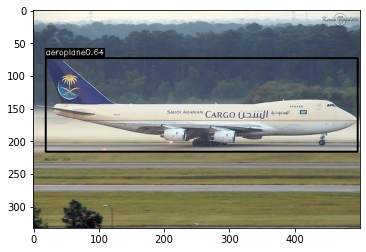

In [16]:
visualize(model, './misc/lab07/Generate_dataset/images/004199.jpg')

car0.84


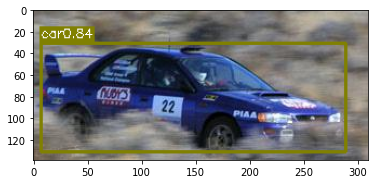

In [17]:
visualize(model, './misc/lab07/Generate_dataset/images/006034.jpg')

### Step 6-2. Inference (mAP)
- The below code is for checkout your network performance,
- By using this code, your network prediction is saved in Generate_dataset directory
- Then, %run ./misc/lab07/Generate_dataset/main.py
- After a few seconds, the mAP is printed.
- **Note that if your code is correct, the mAP will be over 69.**

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

SMALL_VOC_CLASSES = ('aeroplane', 'bicycle', 'bus', 'car', 'cat', 'dog')
os.makedirs('predicted', exist_ok=True)

def write(model, path):
    result = []
    image = cv2.imread(path)
    h, w, _ = image.shape
    img = cv2.resize(image, (448, 448))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    transform = transforms.Compose([transforms.ToTensor(),])
    img = 2 * transform(img) - 1
    img = Variable(img[None,:,:,:],volatile=True)
    img = img.cuda()
    
    pred = model(img) #1x7x7x30
    pred = pred.cpu()
    boxes,cls_indexs,probs =  interpret_target(pred, 0)
    
    
    txt_file = open(os.path.join('predicted', os.path.basename(path)[:-4]+'.txt'), 'w')
    
    for i, box in enumerate(boxes):
        
        x1 = max(int(box[0] * w), 0)
        x2 = min(int(box[2] * w), w)
        y1 = max(int(box[1] * h), 0)
        y2 = min(int(box[3] * h), h)
        cls_index = cls_indexs[i]
        cls_index = int(cls_index)
        prob = probs[i]
        prob = float(prob)
        txt_file.write(str(SMALL_VOC_CLASSES[cls_index])+' '+'%.6f'%(prob)+' '+str(x1)+' '+str(y1)+' '+str(x2)+' '+str(y2))
        txt_file.write('\n')
    txt_file.close()
    
import glob

model.eval()
img_names = glob.glob('./misc/lab07/Generate_dataset/images/*')

for i, file_name in enumerate(img_names):
    write(model, file_name)
    if i % 500 == 0:
        print(i)

0
500
1000


In [19]:
%run ./misc/lab07/Generate_dataset/main.py

66.56% = aeroplane AP 
67.56% = bicycle AP 
67.97% = bus AP 
67.51% = car AP 
74.46% = cat AP 
77.94% = dog AP 
mAP = 70.33%


<Figure size 432x288 with 0 Axes>

YOLO는 object detection 분야에 선두 주자인 CNN을 도입한 R-CNN을 기반 two-stage detector를 one-stage detector로 paradigm을 변화시킨 모델이다. two-stage detector의 경우에는 object가 있을법한 위치를 detection하고 그 후에 classification을 진행하는데 YOLO는 이 같은 연산을 병렬 처리하기 때문에 빠르다. one-stage detector로 나타내기 위해서 loss function이 복잡하게 새로 구성하였다.

예상했던 점 : YOLO loss로 인해서 one-stage detector로 구현할 수 있었기 때문에 제일 중요한 것이 loss function이고 이에 따라서 속도도 빠르다.

예상과 달랐던 점 및 개선할 점 : 이미 pre-train 된 모델에 추가적인 학습하는 모델이었기 때문에 15 epoch만 돌렸다. epoch가 작아서 그런지 loss값이 크게 변하지 않았다. 그래서 aeroplane과 bicycle bus car은 70%가 넘지 않는 AP의 값을 보였다. 좀 더 정확도를 올릴 방법이 필요하다.

결론 : 결론적으로 object detection task를 real-time으로 성능이 어느정도 보장된 model을 구현했다.

의문점 : YOLO의 단점인 작은 물체의 detection을 위해서 추가적으로 할 수 있는 것이 무엇인가? 

### *References*
[1] https://www.pyimagesearch.com/2018/05/14/a-gentle-guide-to-deep-learning-object-detection/

[2] https://github.com/Cartucho/mAP